# Playground

## Load

In [1]:
from __future__ import annotations
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt
import arviz as az

In [2]:
from m5.data.ready import load_ds, path_ds
# from m5.data.prep import *
# from m5.data.raw import calendar, sell_prices, sales_train_eval, sales_train_valid, sample_submission

In [3]:
ds_all = load_ds()
# ds_all = load_ds(recalc=True)
ds = ds_all.where(ds_all['historic'], drop=True)
vars_int = ['sales', 'wday', 'month', 'year', 'event', 'snap']
for v in vars_int:
    ds[v] = ds[v].astype(int)
ds

<xarray.Dataset>
Dimensions:     (date: 1941, event_name: 30, item_id: 3049, store_id: 10)
Coordinates:
  * item_id     (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id      (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id     (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id    (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id    (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date        (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name  (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type  (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
    historic    (date) bool True True True True True ... True True True True
    future      (date) bool False False False False ... False False False False
Data variables:
    sales       (item_id, store_id, date) int64 3 0 0 1 4 2 0 ... 0 0 0 0 0 0 0
    price       (item_id, store_id, date) float64 2.0 2.0 2.0 ... 5.94 5.94 5.94
    wday        (date) int64 1 2 3 4 5 6 7 1 2 3 4 5 ... 5 6 7 1 2 3 4 5 6 7 1 2
    month       (date) int64 1 1 1 2 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 5 5 5
    year        (date) int64 2011 2011 2011 2011 2011 ... 2016 2016 2016 2016
    event       (date, event_name) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    snap        (date, store_id) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

## EDA

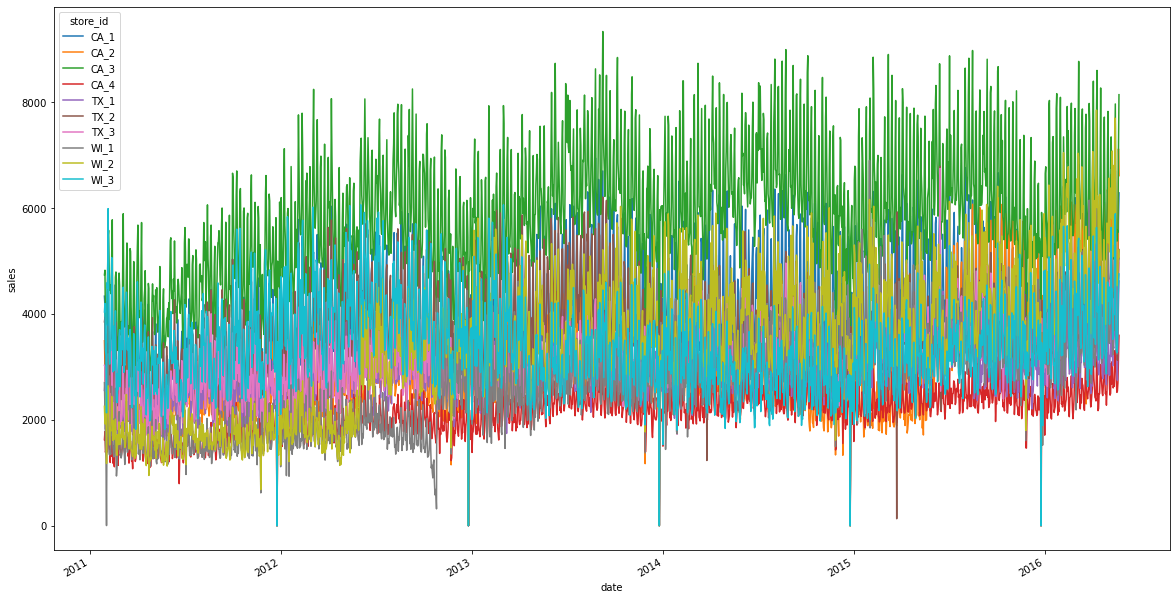

In [4]:
ds['sales'].sum(dim='item_id').plot.line(x='date', figsize=(20, 10));

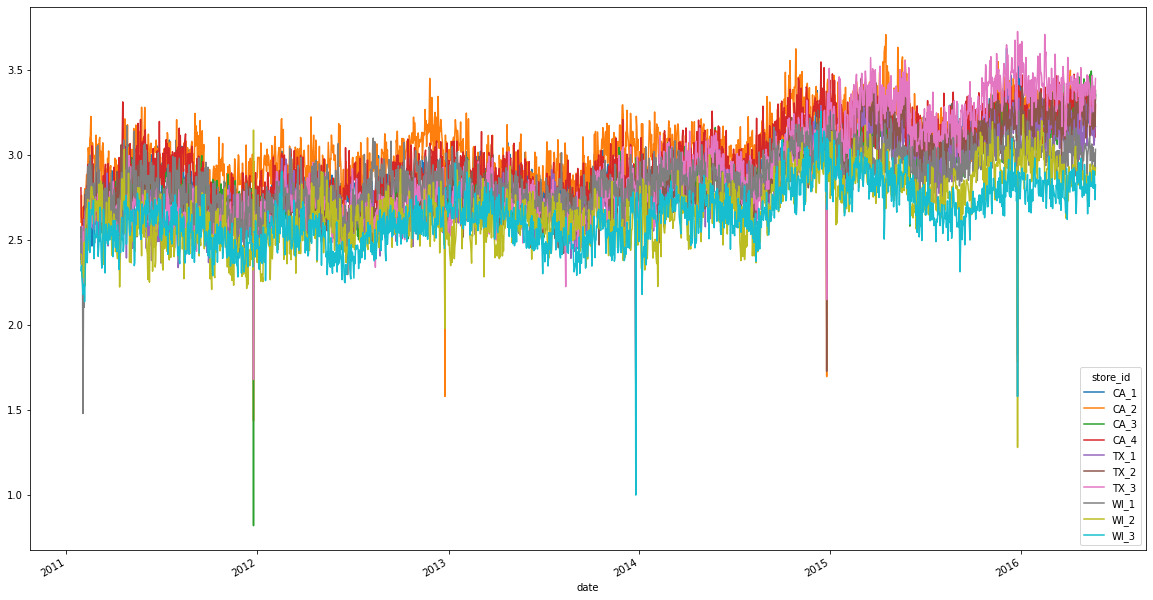

In [5]:
avg_price = (ds['sales'] * ds['price']).sum(dim='item_id') / ds['sales'].sum(dim='item_id')
avg_price.plot.line(x='date', figsize=(20, 10));

In [6]:
ds

<xarray.Dataset>
Dimensions:     (date: 1941, event_name: 30, item_id: 3049, store_id: 10)
Coordinates:
  * item_id     (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id      (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id     (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id    (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id    (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date        (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name  (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type  (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
    historic    (date) bool True True True True True ... True True True True
    future      (date) bool False False False False ... False False False False
Data variables:
    sales       (item_id, store_id, date) int64 3 0 0 1 4 2 0 ... 0 0 0 0 0 0 0
    price       (item_id, store_id, date) float64 2.0 2.0 2.0 ... 5.94 5.94 5.94
    wday        (date) int64 1 2 3 4 5 6 7 1 2 3 4 5 ... 5 6 7 1 2 3 4 5 6 7 1 2
    month       (date) int64 1 1 1 2 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 5 5 5
    year        (date) int64 2011 2011 2011 2011 2011 ... 2016 2016 2016 2016
    event       (date, event_name) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    snap        (date, store_id) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

## Model

In [78]:
x = ds.where(ds["store_id"] == "CA_1", drop=True).where(
    ds["dept_id"] == "FOODS_1", drop=True
)

In [1]:
x

NameError: name 'x' is not defined

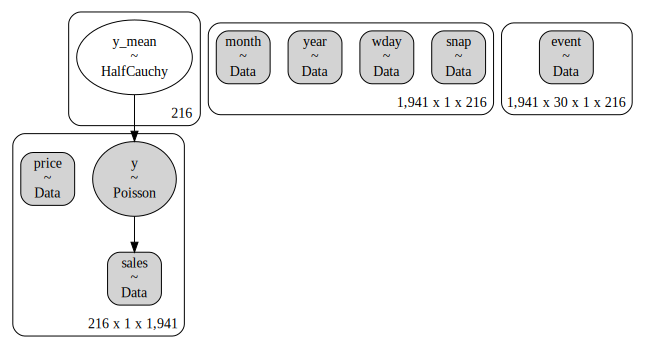

In [80]:
with pm.Model(coords=x.coords) as m:
    for k, v in x.data_vars.items():
        pm.Data(k, v, dims=v.dims)
        
    pm.HalfNormal('y_mean', beta=2, dims=['item_id'])
    pm.Uniform()
    psi = 
    theta = m['y_mean'][:, np.newaxis, np.newaxis]
    pm.ZeroInflatedPoisson('y', psi=psi, theta=theta, dims=['item_id', 'store_id', 'date'], observed=m['sales'])

gv = pm.model_to_graphviz(m)
gv

### Fit

In [9]:
with m:
    trace = pm.sample(draws=200, tune=100, chains=1, target_accept=0.8, return_inferencedata = True)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [y_mean]


Sampling 1 chain for 100 tune and 43 draw iterations (100 + 43 draws total) took 866 seconds.


0, dim: item_id, 1437 =? 1437
1, dim: store_id, 4 =? 4
2, dim: date, 1941 =? 1941


The acceptance probability does not match the target. It is 0.9654544736887184, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [43]:
with m:
    ppc_raw = pm.sample_posterior_predictive(trace.posterior)
    ifd2 = az.from_pymc3(posterior_predictive=ppc_raw)
ppc = ifd2.posterior_predictive
# dims = ['sample', 'item_id', 'store_id', 'date']
# coords = {k: x.coords[k] for k in dims if k in x.coords}
# ppc = xr.DataArray(ppc_raw['y'], dims=dims, coords=coords).to_dataset(name='y')

In [44]:
ppc

<xarray.Dataset>
Dimensions:   (chain: 1, date: 1941, draw: 43, item_id: 1437, store_id: 4)
Coordinates:
  * chain     (chain) int64 0
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 33 34 35 36 37 38 39 40 41 42
  * item_id   (item_id) object 'FOODS_1_001' 'FOODS_1_002' ... 'FOODS_3_827'
  * store_id  (store_id) object 'CA_1' 'CA_2' 'CA_3' 'CA_4'
  * date      (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
Data variables:
    y         (chain, draw, item_id, store_id, date) int64 4 2 0 4 0 ... 0 0 1 2
Attributes:
    created_at:                 2021-01-20T11:02:18.291831
    arviz_version:              0.11.0
    inference_library:          pymc3
    inference_library_version:  3.10.0

In [48]:
y_hat = ppc['y'].mean(dim=['chain', 'draw'])

In [70]:
z = xr.merge([x, ppc, ppc.mean(dim=['chain', 'draw']).rename({"y": "y_mean"})])

### Check

In [65]:
a1 = x['sales'].values.ravel()
a2 = y_hat.values.ravel()
a3 = x['store_id'].values
a3 = np.tile(a3, int(len(a1)/len(a3)))

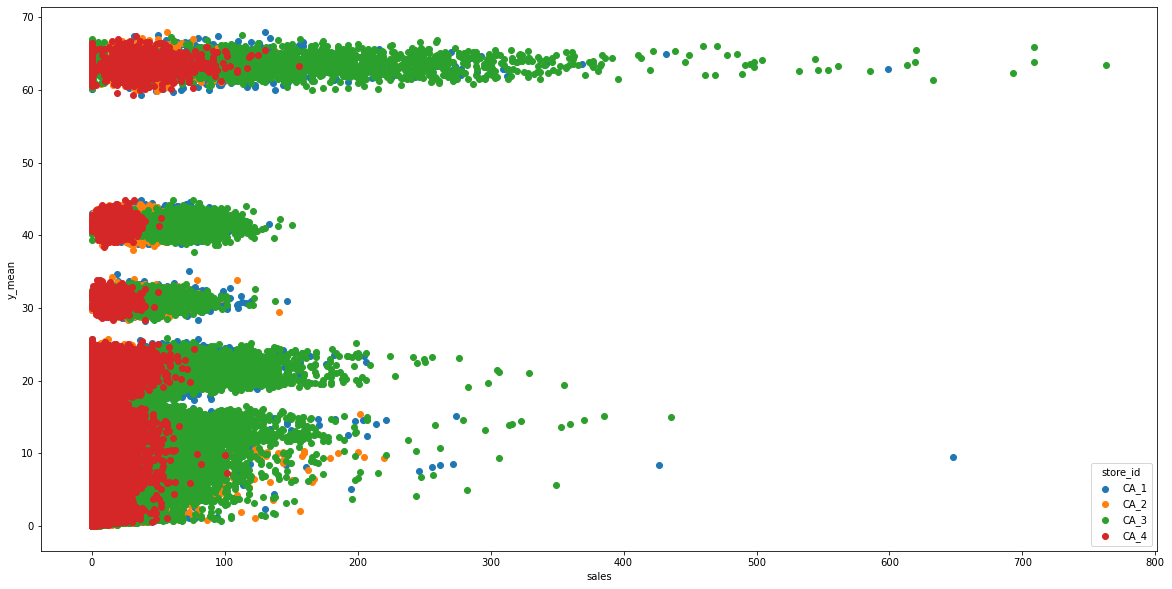

In [77]:
fig, ax = plt.subplots(figsize=(20,10))
z.plot.scatter('sales', 'y_mean', ax=ax, hue='store_id')
fig;

In [52]:
(x['sales'] - y_hat).mean(dim=['item_id', 'date'])

<xarray.DataArray (store_id: 4)>
array([ 0.14092934, -0.54172946,  0.91324564, -0.79137955])
Coordinates:
  * store_id  (store_id) object 'CA_1' 'CA_2' 'CA_3' 'CA_4'
    state_id  (store_id) object 'CA' 'CA' 'CA' 'CA'